In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import time
import math

In [2]:
# Configuration variables
a = 2
q = 9
u_init = 0.09
omega = 1

rho_o = 0.5
u_o = 0.5

nx = 10
ny = 15

# Density weight contribution along the q different directions
w_i = np.array([4/9, 1/9, 1/9, 1/9, 1/9, 1/36, 1/36, 1/36, 1/36])

# Velocity components
c_ai = np.array([[0, 1, 0, -1, 0, 1, -1, -1, 1],    # Velocity x-component
              [0, 0, 1, 0, -1, 1, 1, -1, -1]])   # Velocity y-component

# debug flags
collision = True

In [23]:
def function_f_default(nx=nx, ny=ny):
    return np.einsum("i,jk->ijk", w_i, np.ones((nx, ny)))

def rho_nm(f_inm):
    """
    Measured density
    """
    return np.einsum("ijk->jk", f_inm)

def u_anm(f):
    """
    Measured velocity
    """
    return np.einsum('ai,ijk->ajk',c_ai,f)/rho_nm(f)

def f_next_delta_t(f):
    for i in range(f.shape[0]):
        f[i] = np.roll(f[i], shift = c_ai.T[i], axis=[0,1])
    rho = rho_nm(f)
    u = u_anm(f)
    if collision:
        feq = f_eq(rho, u)
        f = f + (omega * (feq - f))
    return f, rho, u

def streaming(f_inm):
    f_inm, _, _ = f_next_delta_t(f)
#     rho = rho_nm(f_inm)
#     u = u_anm(f_inm)
    return f_inm

def check_mass_conservation(f1, f2):
    f1_mass = rho_nm(f1).sum()
    f2_mass = rho_nm(f2).sum()
#     print(f1_mass, f2_mass)
    np.testing.assert_almost_equal(f1_mass,f2_mass, decimal=2)

def plot_density(arr, plt_index=None):
    %matplotlib inline
    
    fig, ax = plt.subplots()
    if plt_index is not None:
        ax.set_title(f"Step {plt_index}")
    ax.imshow(arr)

def plot_next_stream(f_inm, plt_index=None):
    f_inm_stream = streaming(f_inm)
    check_mass_conservation(f_inm, f_inm_stream)
    
    rho = rho_nm(f_inm_stream)
    u = u_anm(f_inm_stream)
    
    plot_density(rho, plt_index)
    return f_inm_stream, rho, u

def c_ai_x_u_nm(c, u):
    return np.einsum('ai,anm->inm', c, u)

def u_anm_x_u_anm(u):
    return np.einsum('anm->nm',u**2)[np.newaxis,:,:]

def squared_3x3(x):
    return np.einsum('anm,anm->anm', x, x)

def c_power_x(x):
    return math.pow(c, x)

def f_eq(rho, u):
    cu = c_ai_x_u_nm(c_ai, u)
    uu = u_anm_x_u_anm(u)
#     c2 = math.pow(u_init, 2)
#     c4 = math.pow(u_init, 4)
    term = 1 + (3 * cu) + (4.5 * squared_3x3(cu)) - (1.5 * uu)
    term = np.einsum('jk,ijk->ijk', rho_nm(f), term)
    term = np.einsum('i,ijk->ijk', w_i, term)
    return term

def f_initialize(rho, u):
    f = function_f_default()
    if collision:
        feq = f_eq(rho, u)
        f = f + (omega * (feq - f))
    return f, rho, u

In [24]:
f = function_f_default()
f[:, nx//2, ny//2] = 0.99*f[:, nx//2, ny//2]
f[:, nx//4, ny//4] = 1.01*f[:, nx//4, ny//4]

(array([[[0.44444444, 0.44444444, 0.44444444, ..., 0.44444444,
          0.44444444, 0.44444444],
         [0.44444444, 0.44444444, 0.4445678 , ..., 0.44444444,
          0.44444444, 0.44444444],
         [0.44444444, 0.44444444, 0.44493745, ..., 0.44444444,
          0.44444444, 0.44444444],
         ...,
         [0.44444444, 0.44444444, 0.44444444, ..., 0.44444444,
          0.44444444, 0.44444444],
         [0.44444444, 0.44444444, 0.44444444, ..., 0.44444444,
          0.44444444, 0.44444444],
         [0.44444444, 0.44444444, 0.44444444, ..., 0.44444444,
          0.44444444, 0.44444444]],
 
        [[0.11111111, 0.11111111, 0.11111111, ..., 0.11111111,
          0.11111111, 0.11111111],
         [0.11111111, 0.11111111, 0.1110494 , ..., 0.11111111,
          0.11111111, 0.11111111],
         [0.11111111, 0.11111111, 0.11123436, ..., 0.11111111,
          0.11111111, 0.11111111],
         ...,
         [0.11111111, 0.11111111, 0.11111111, ..., 0.11111111,
          0.11111111, 0.

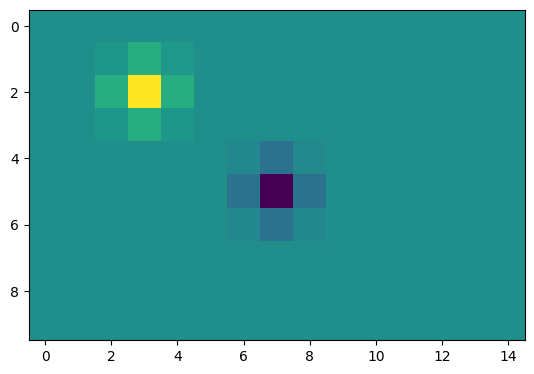

In [25]:
plot_next_stream(f)

/var/folders/ks/nb77wdzs15z43j_271nxw3zc0000gn/T/ipykernel_6719/4079744320.py:41: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


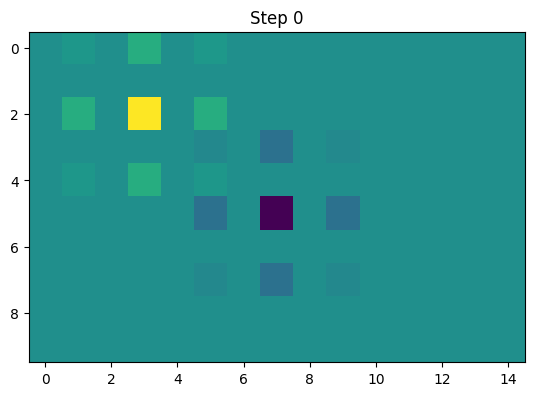

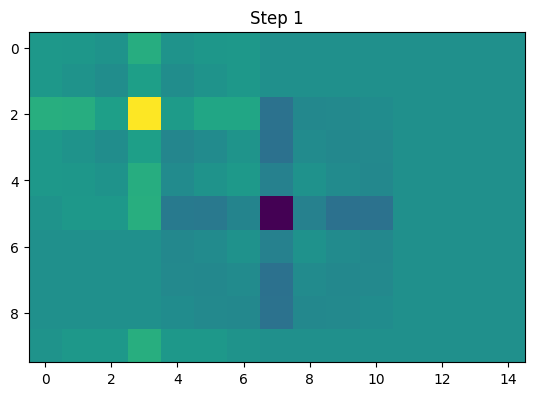

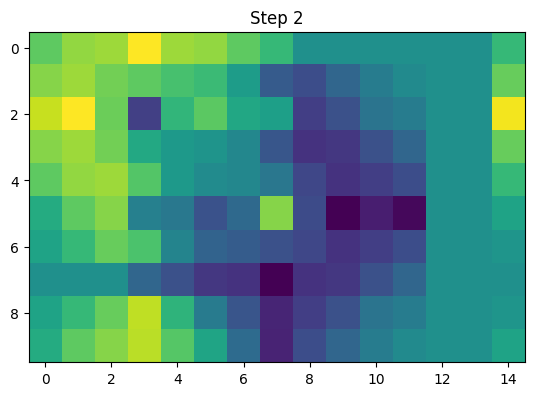

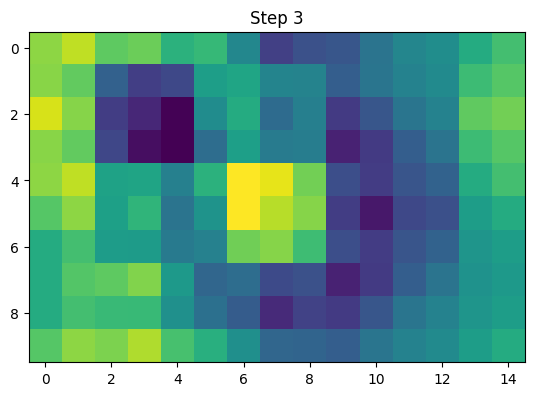

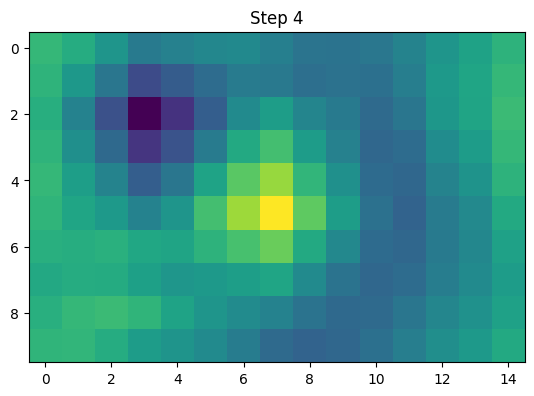

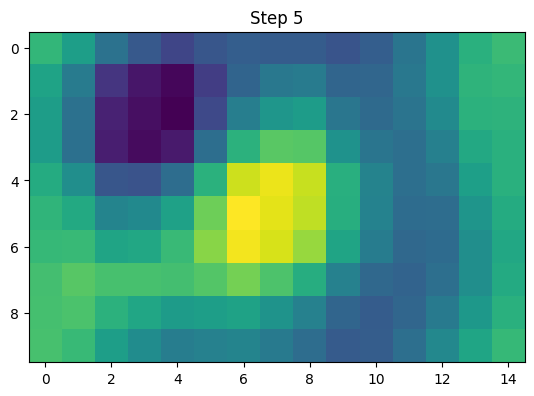

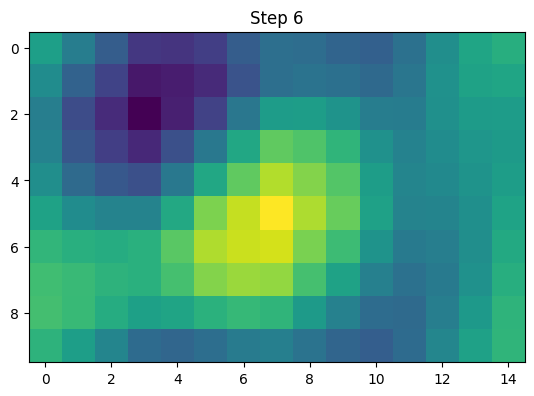

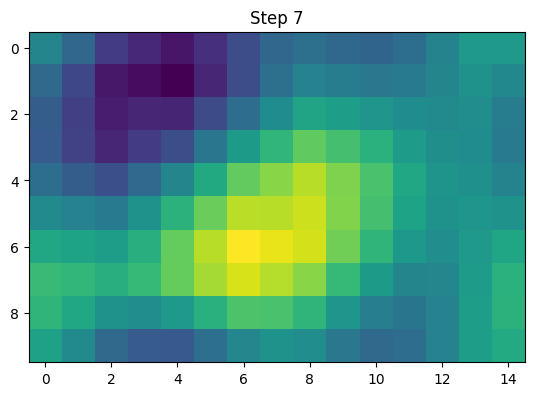

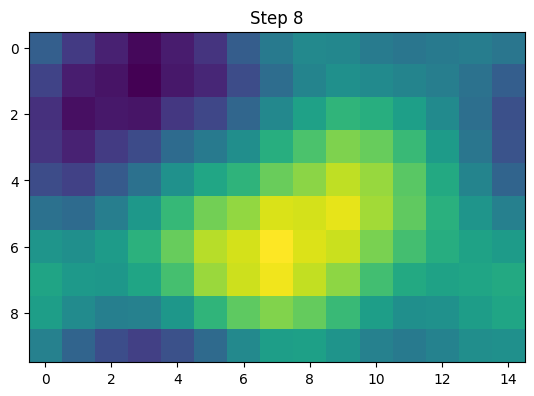

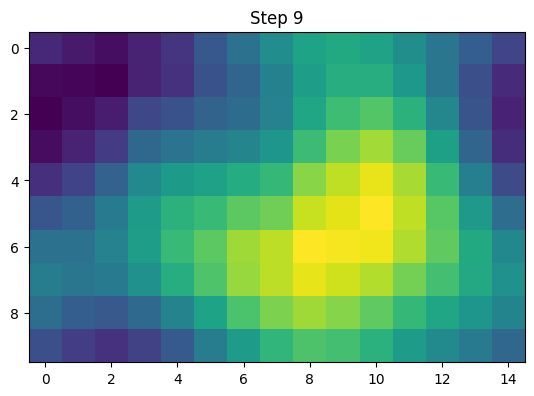

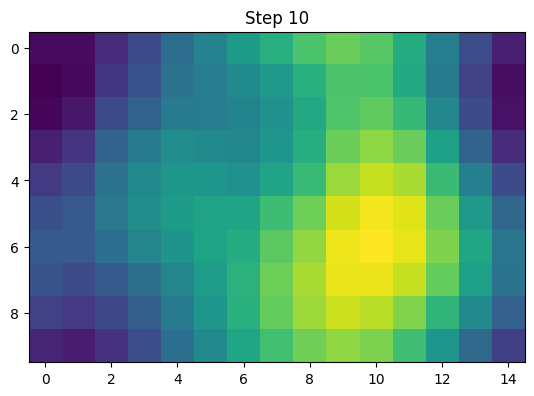

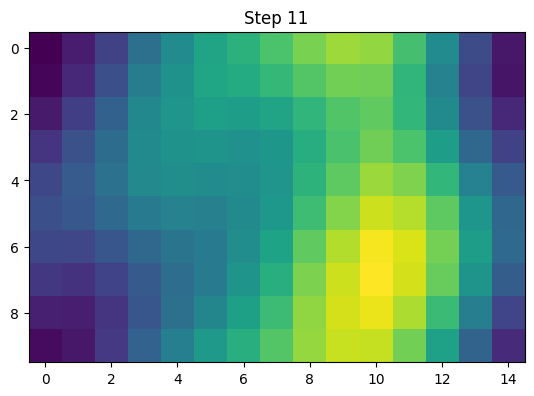

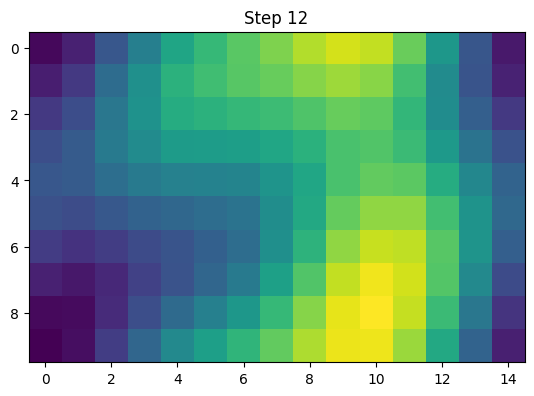

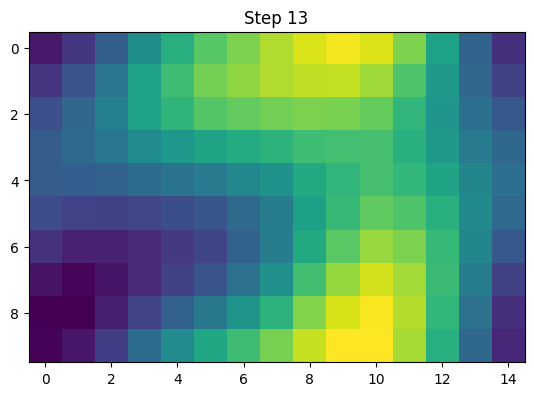

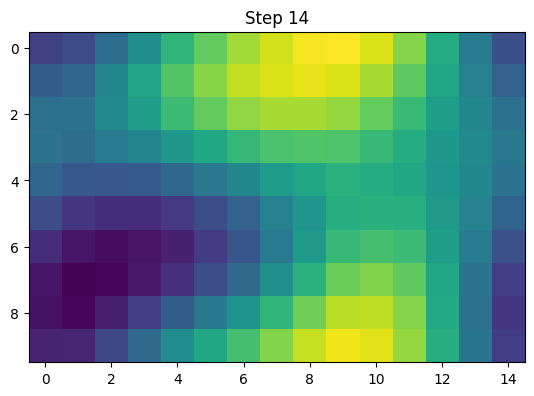

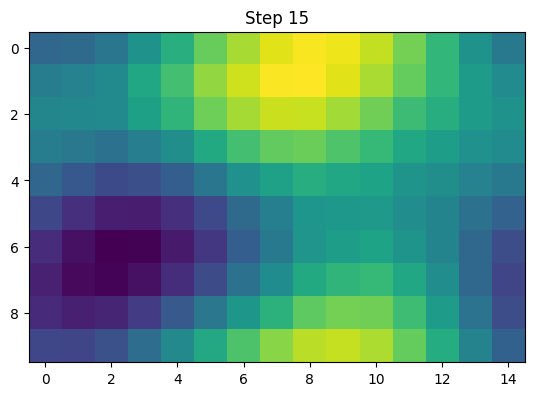

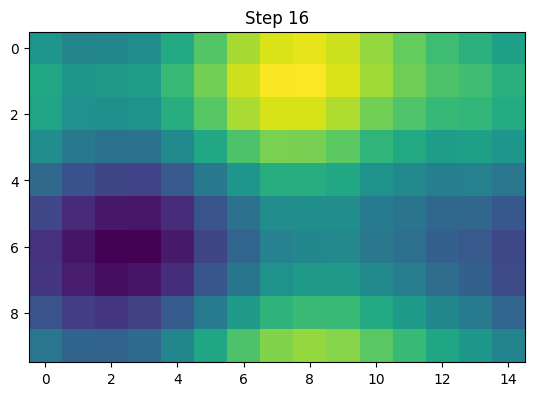

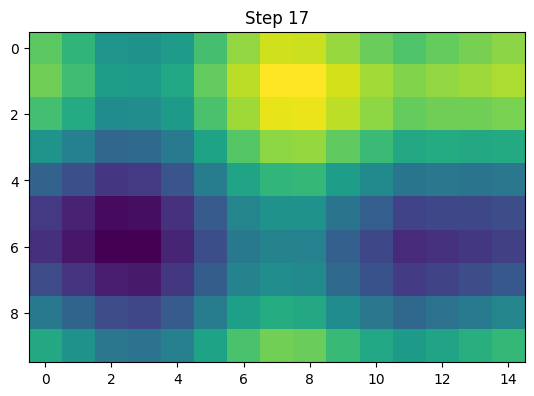

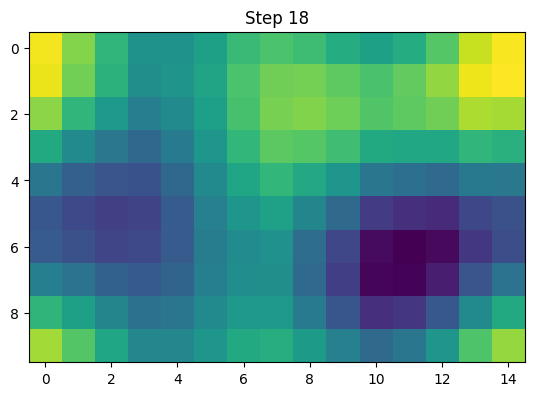

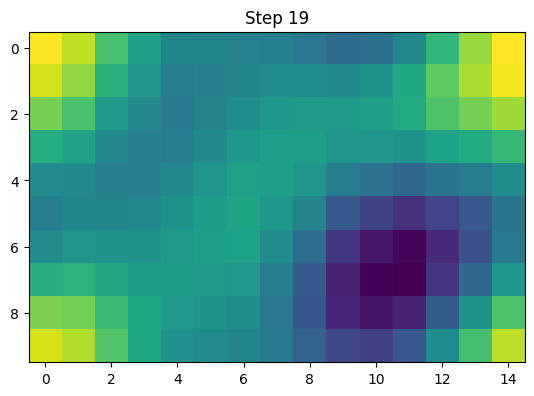

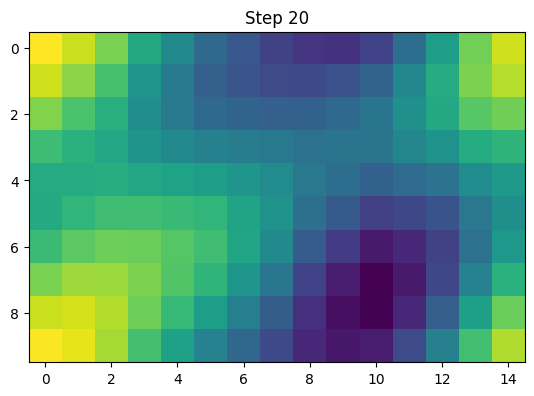

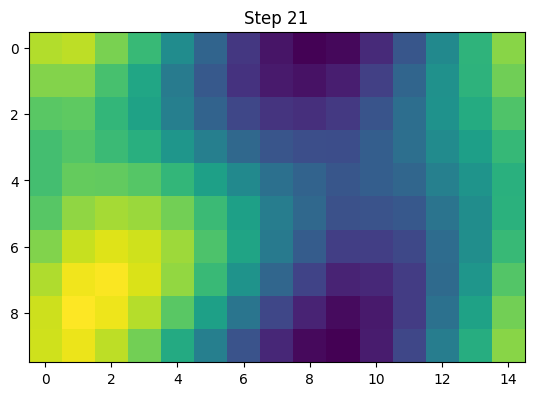

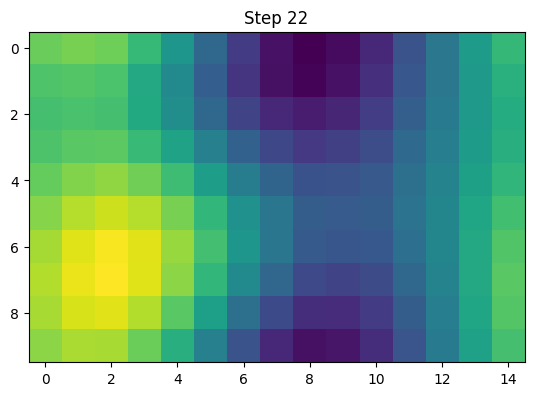

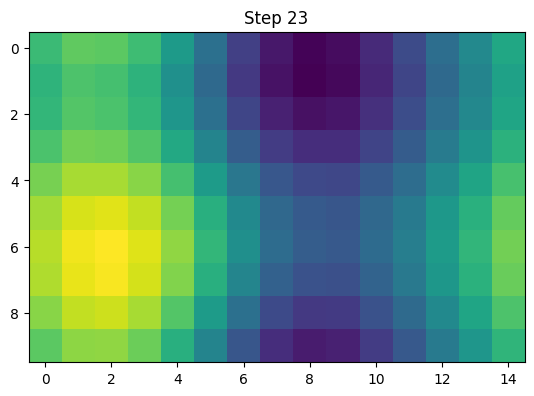

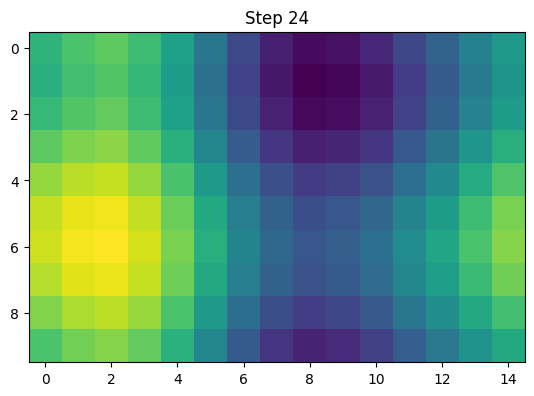

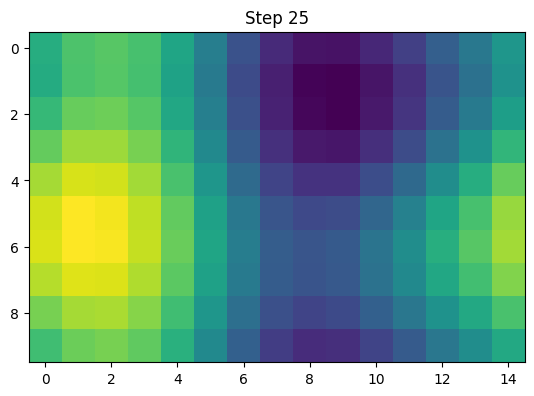

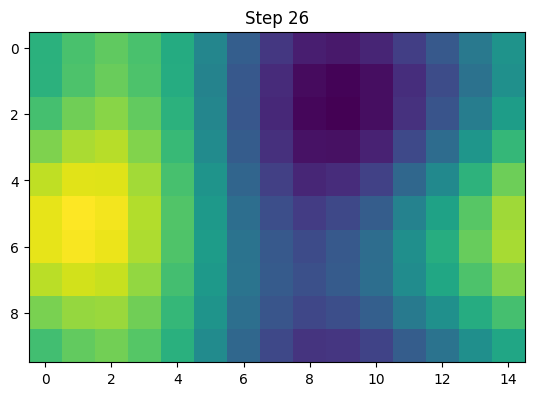

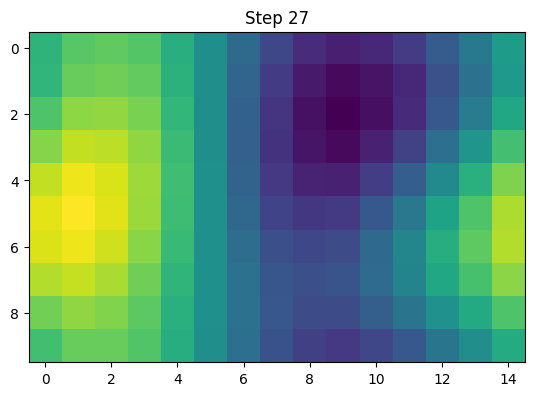

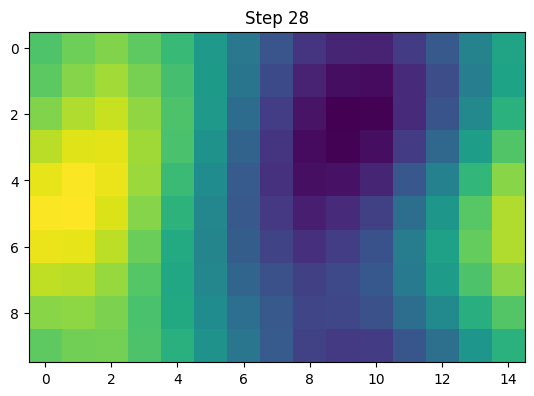

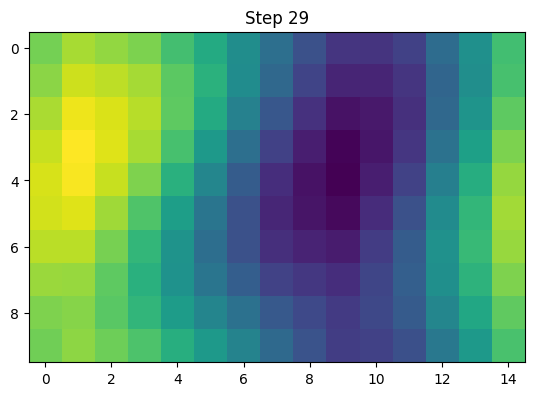

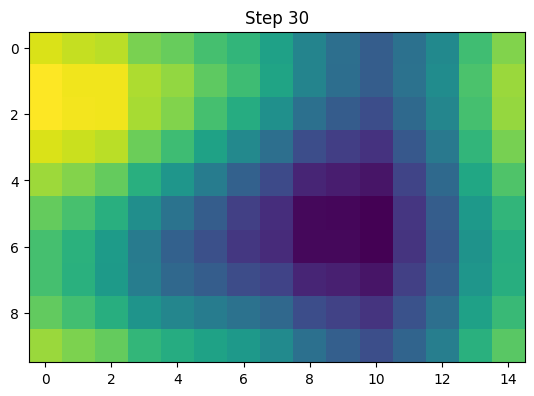

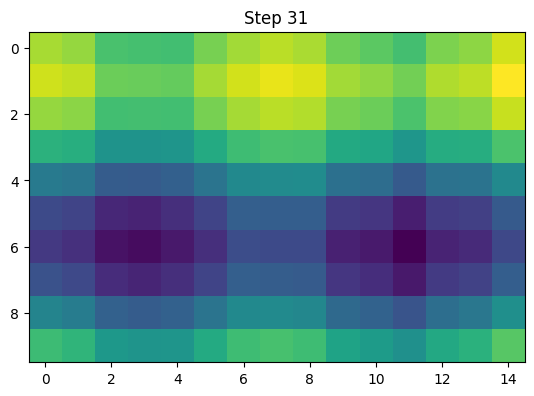

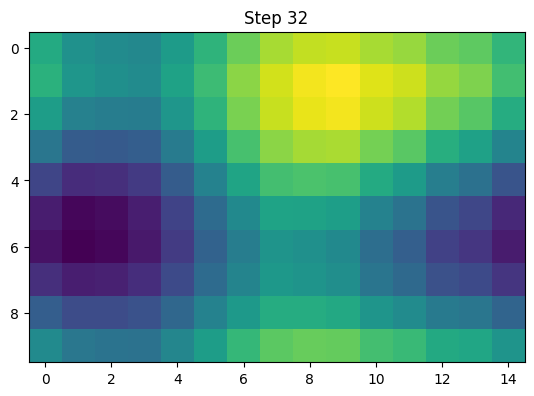

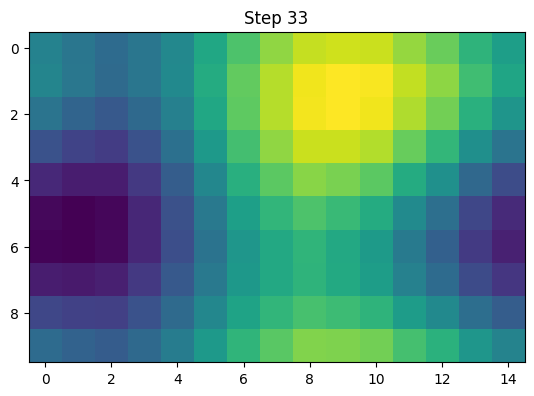

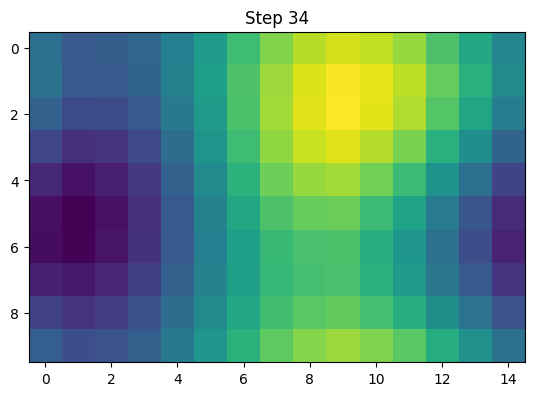

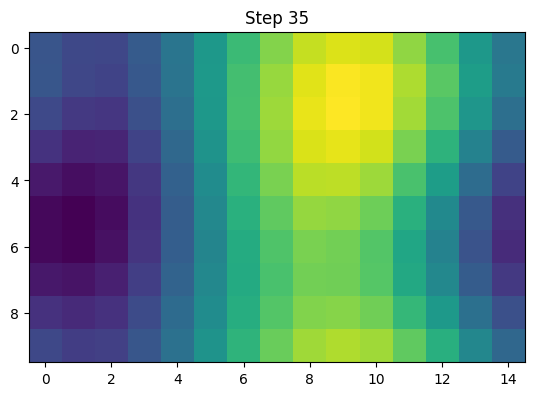

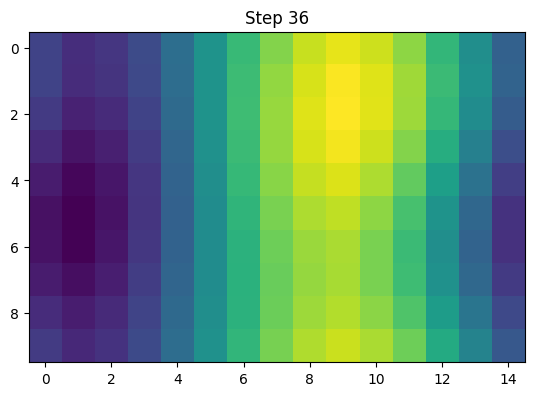

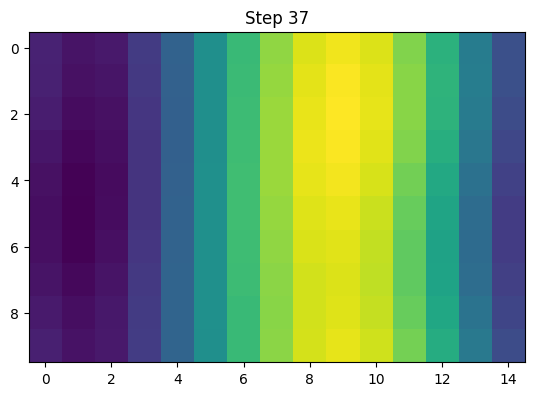

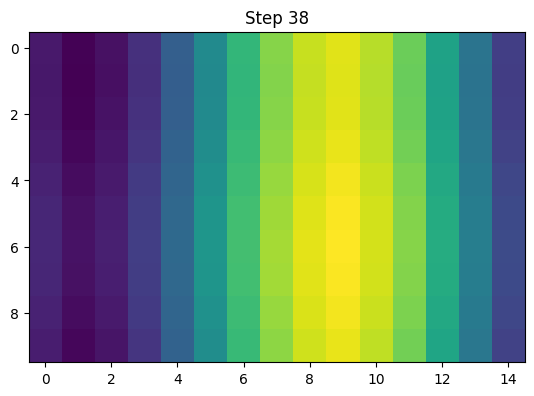

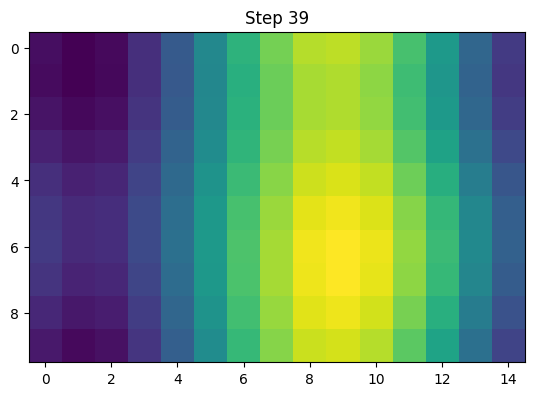

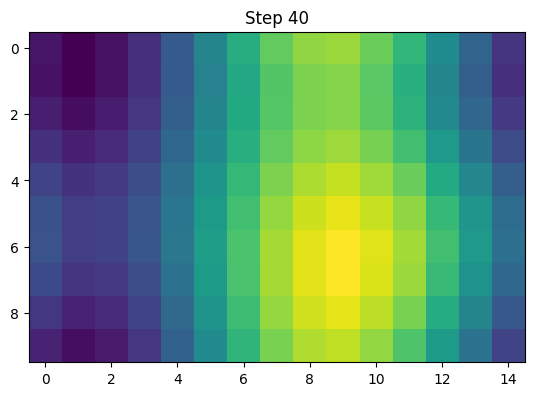

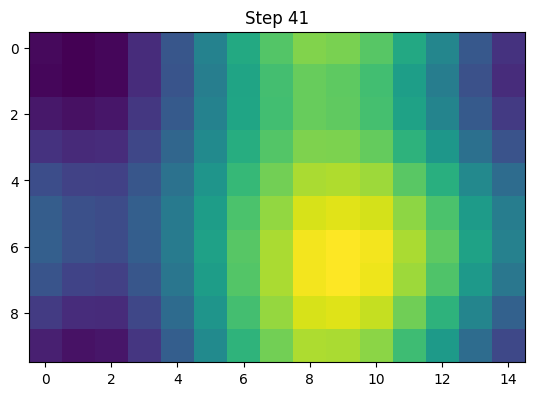

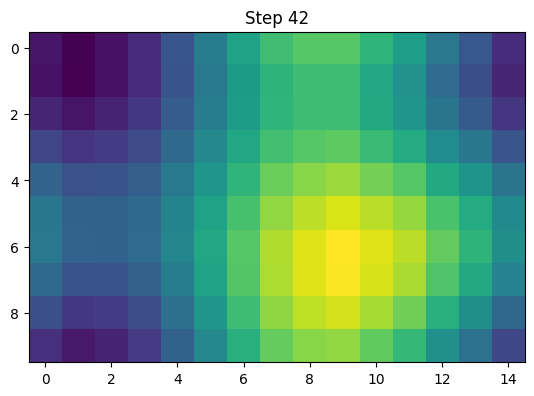

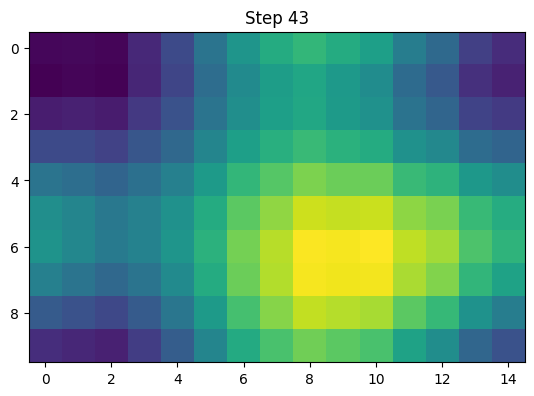

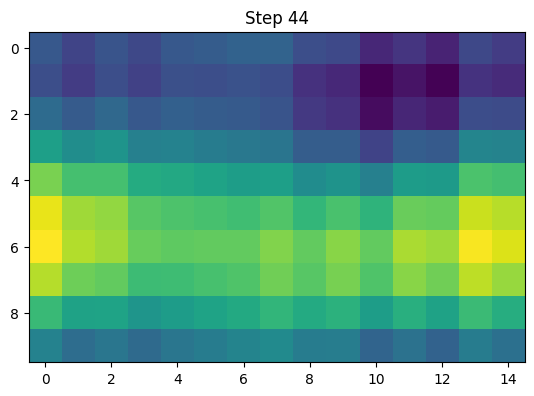

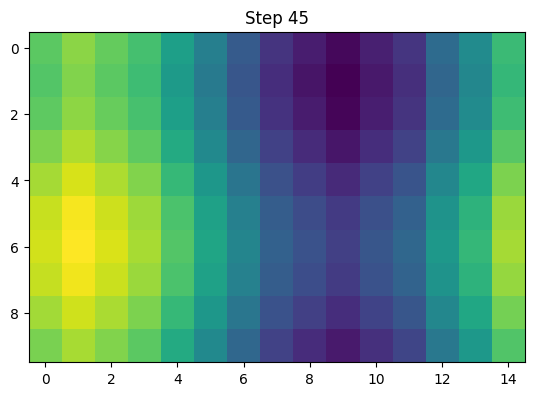

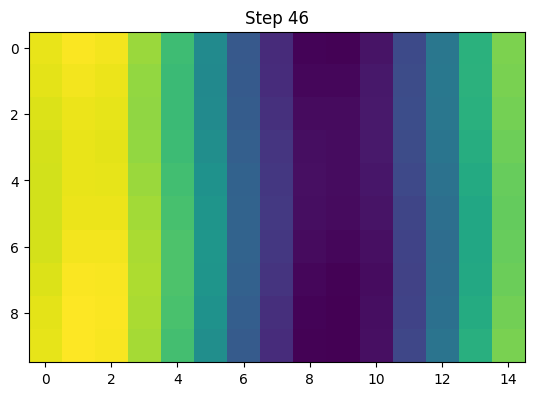

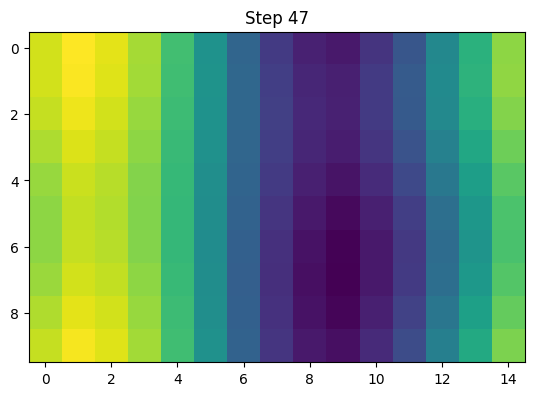

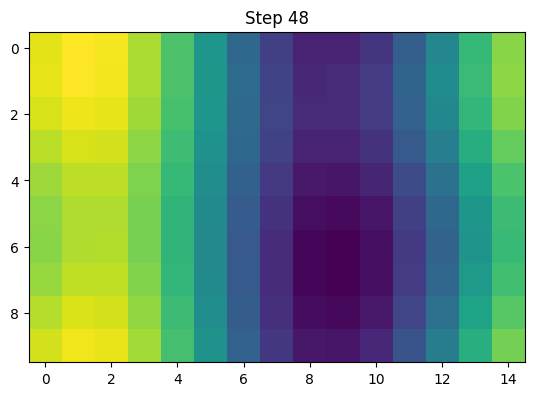

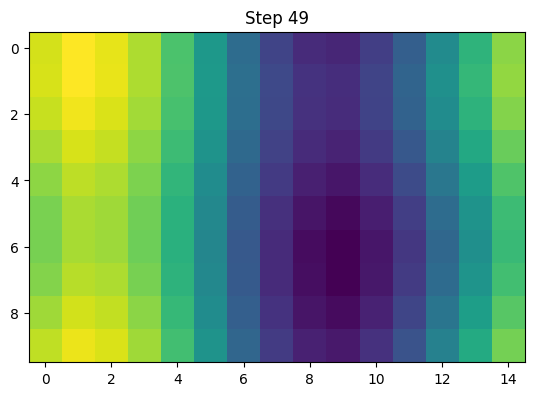

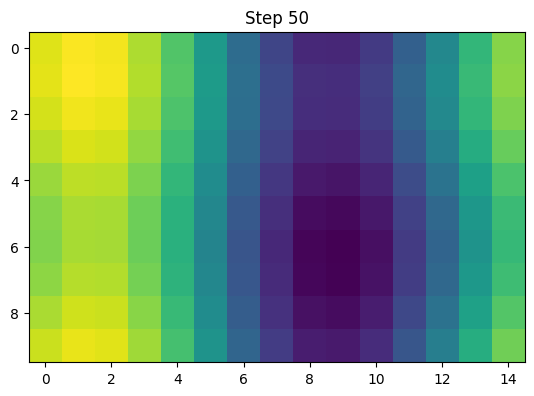

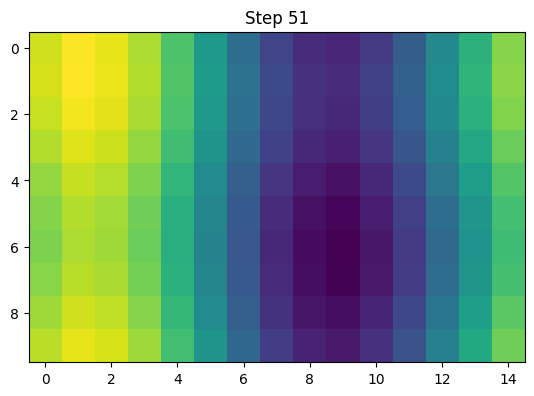

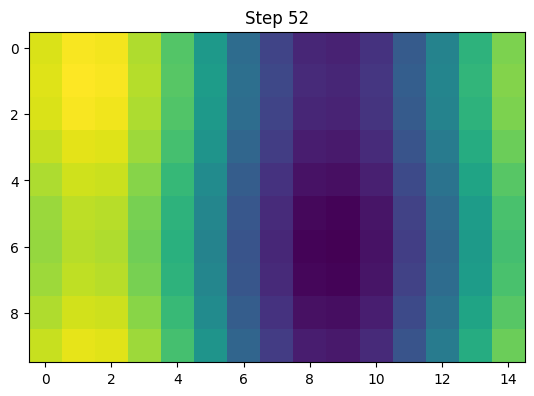

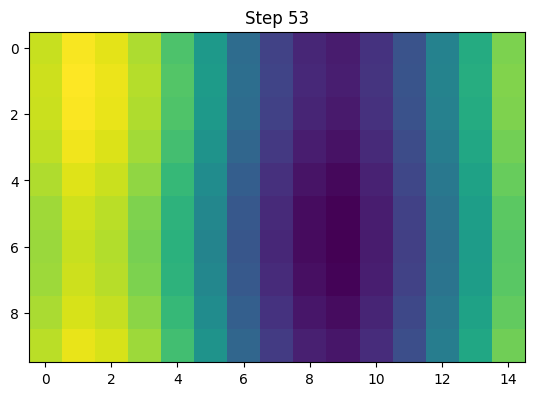

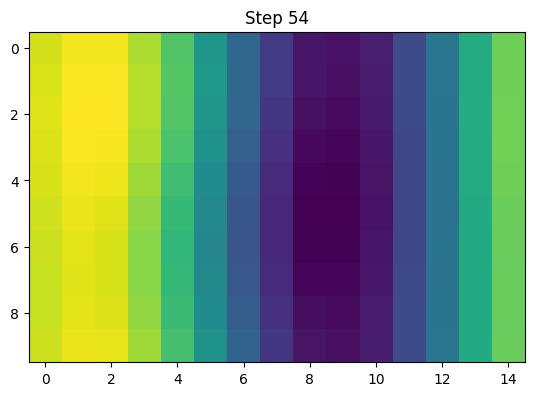

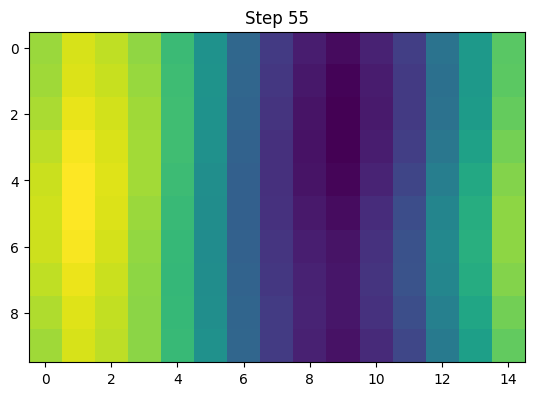

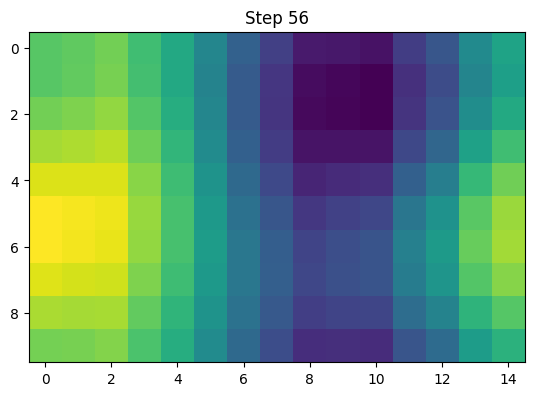

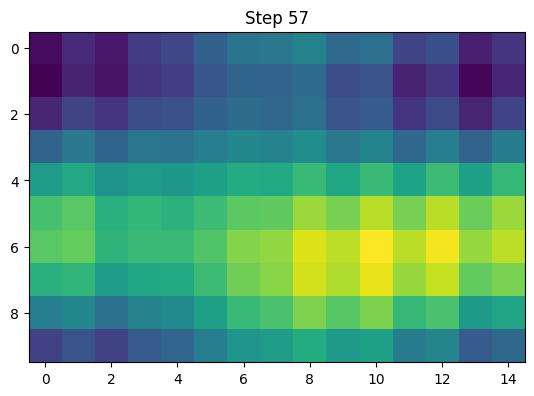

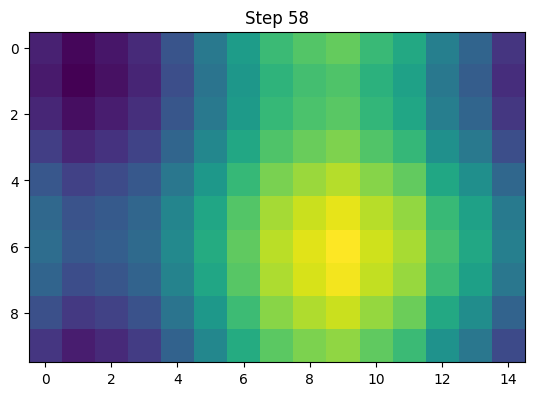

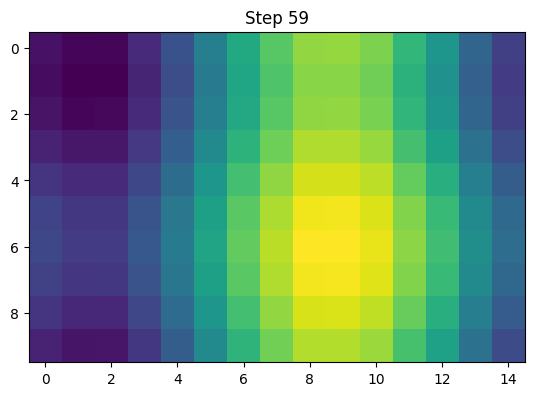

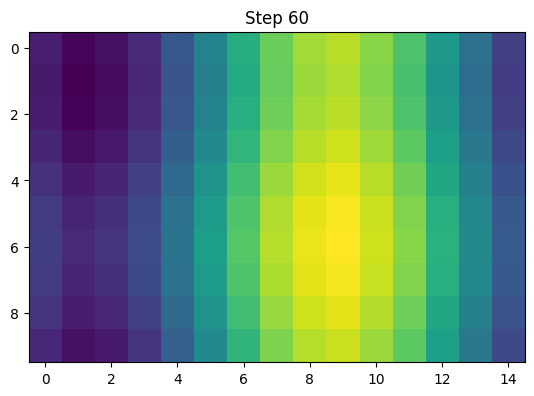

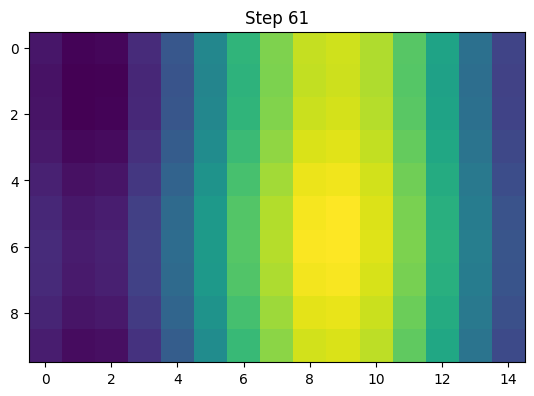

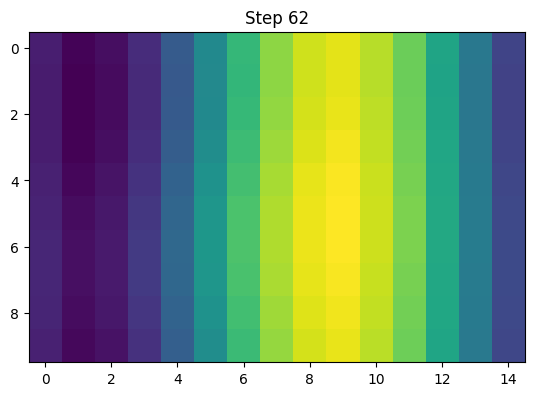

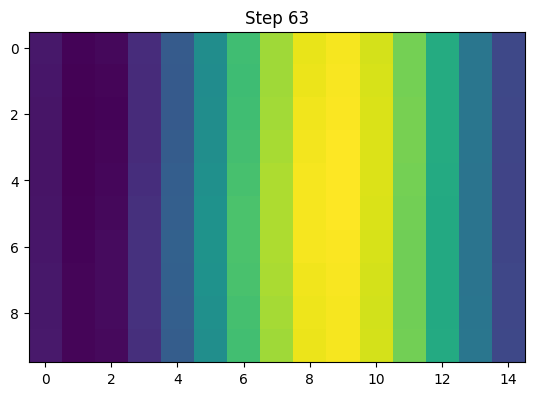

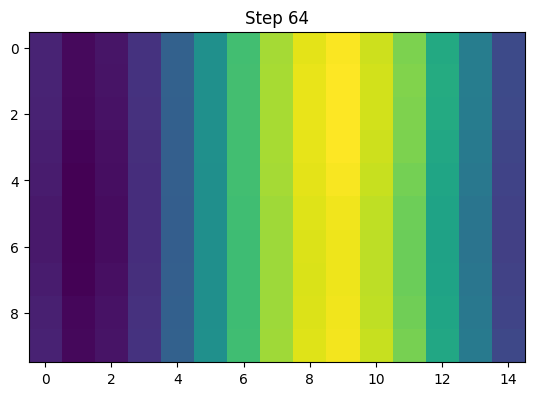

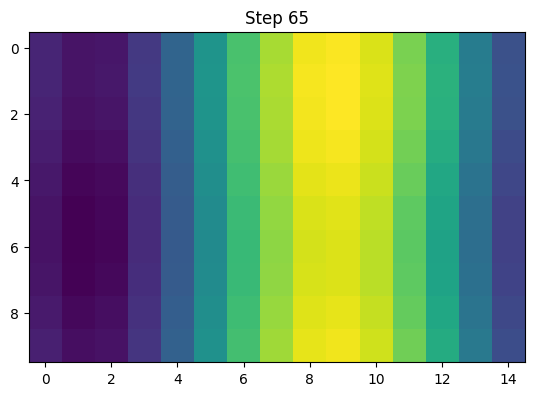

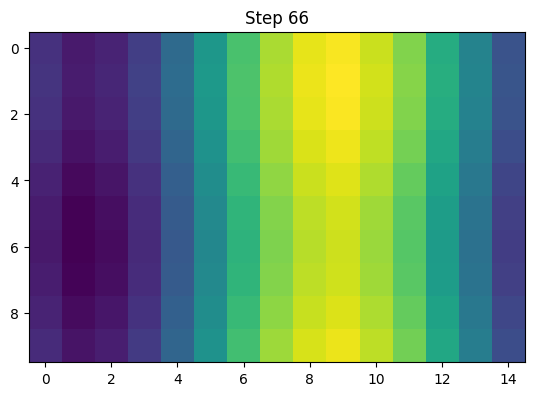

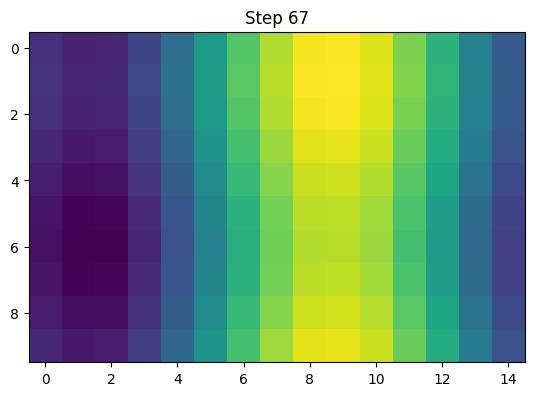

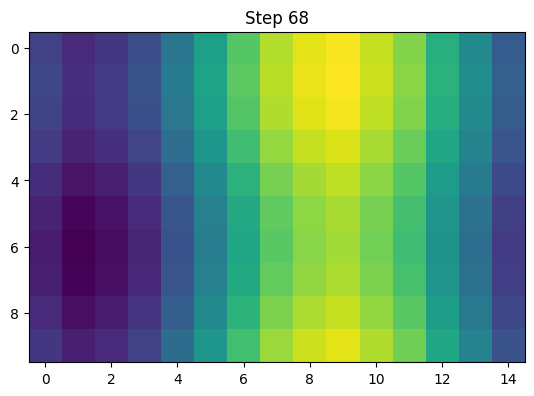

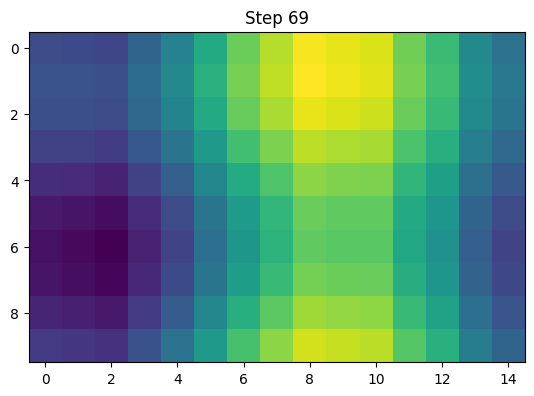

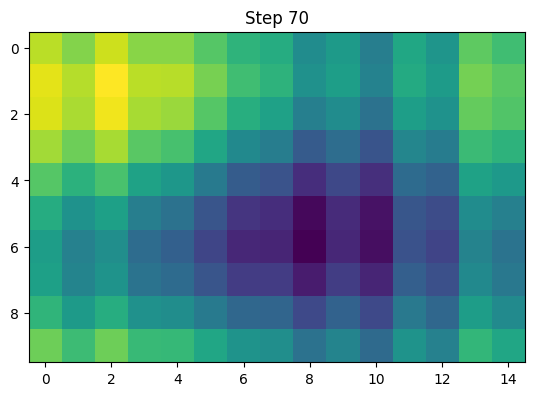

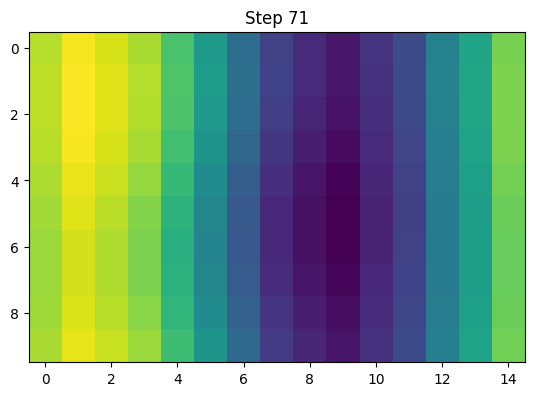

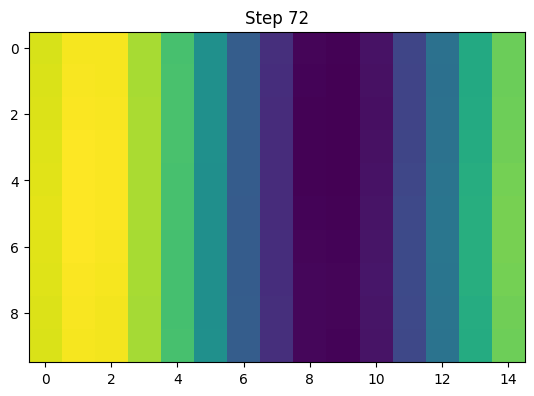

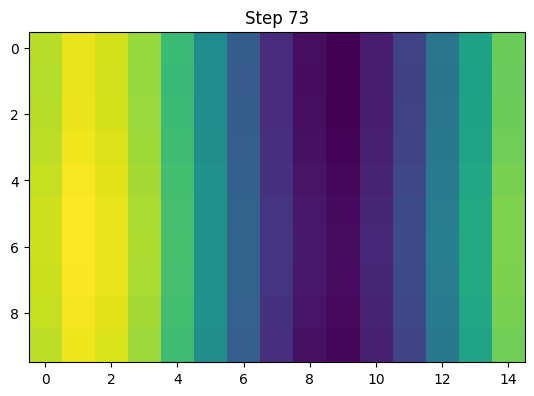

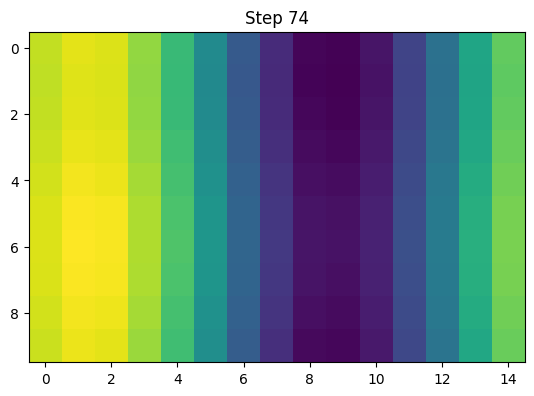

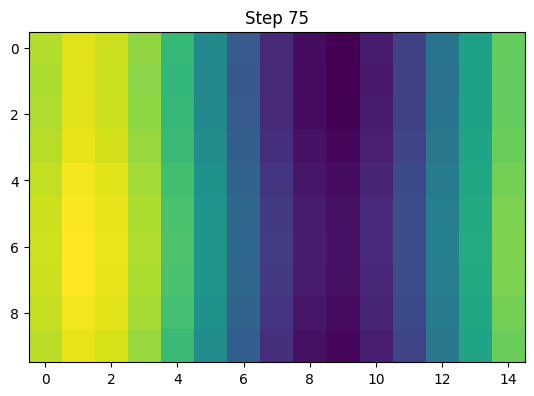

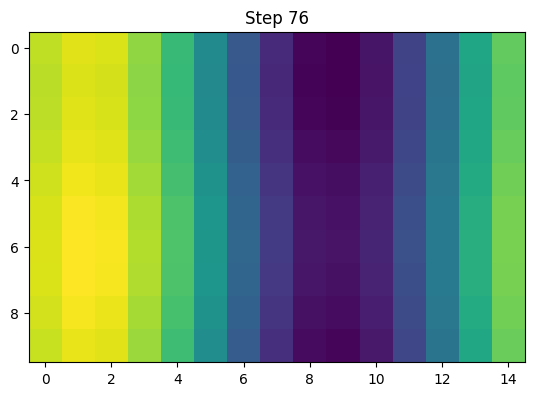

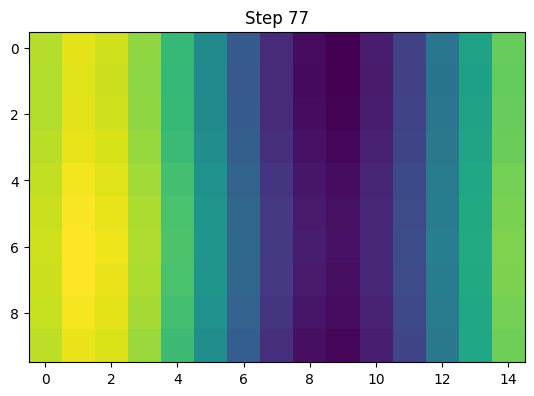

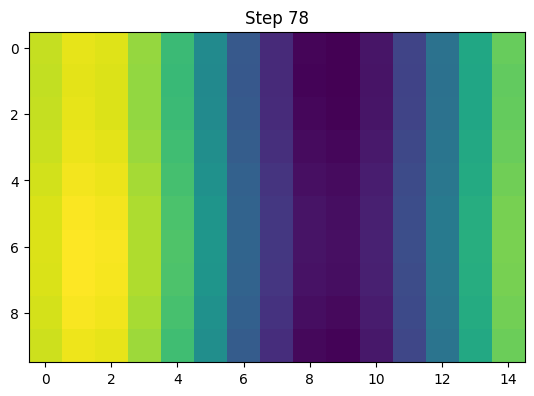

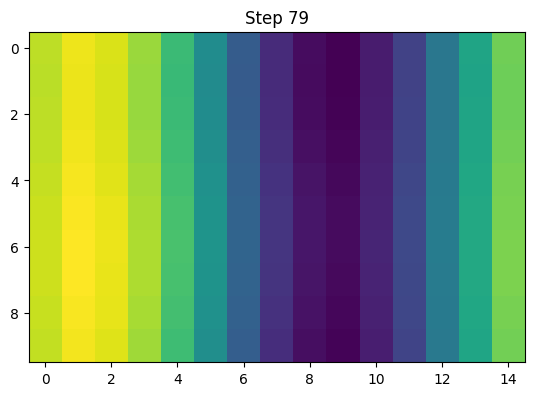

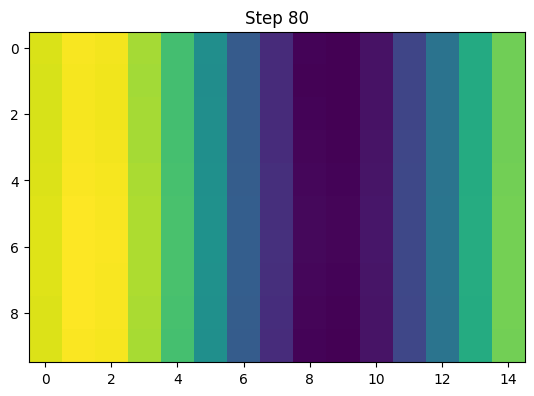

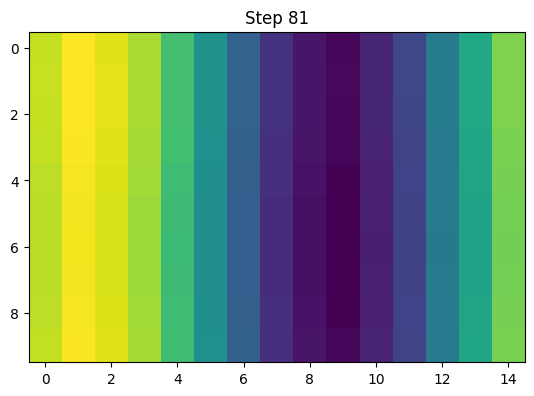

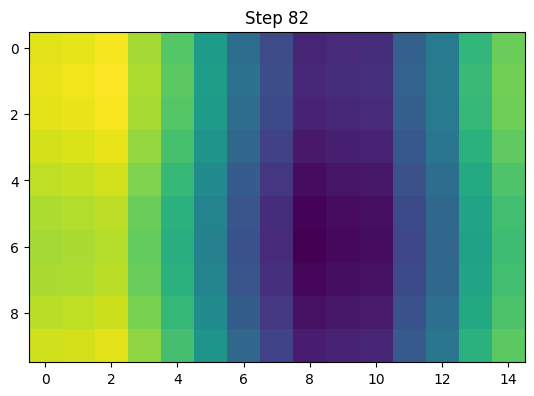

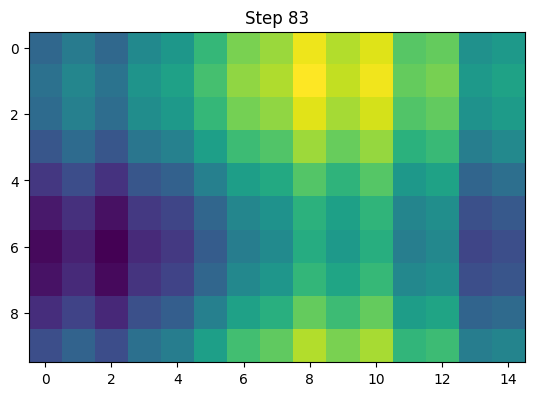

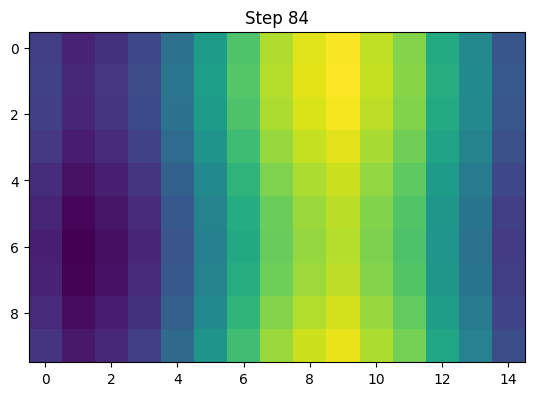

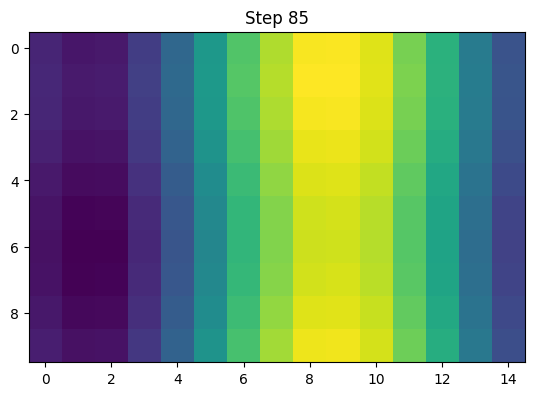

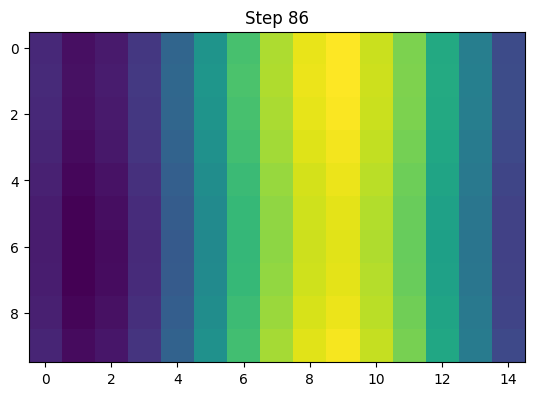

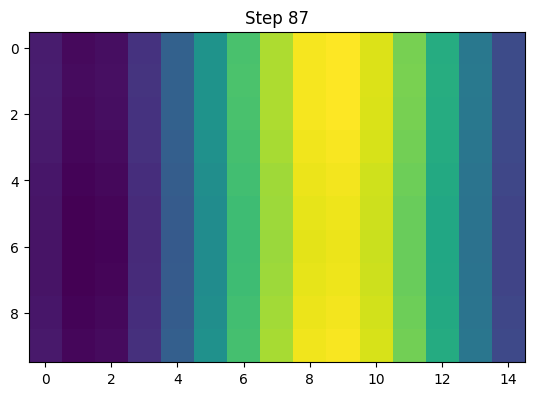

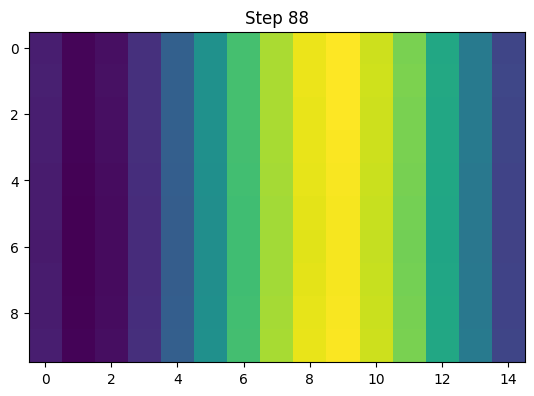

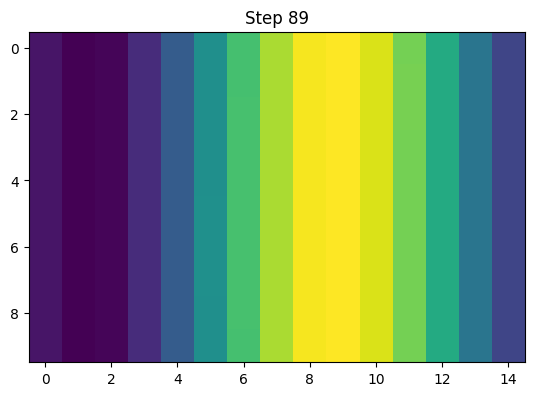

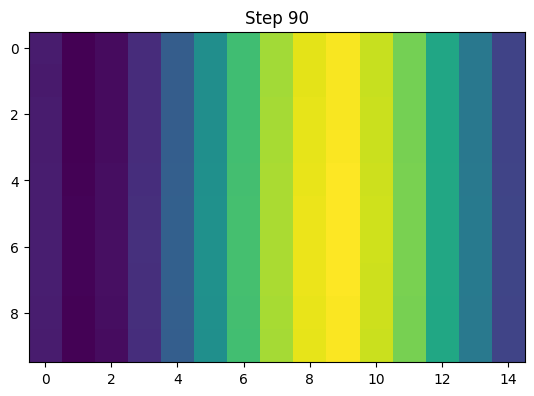

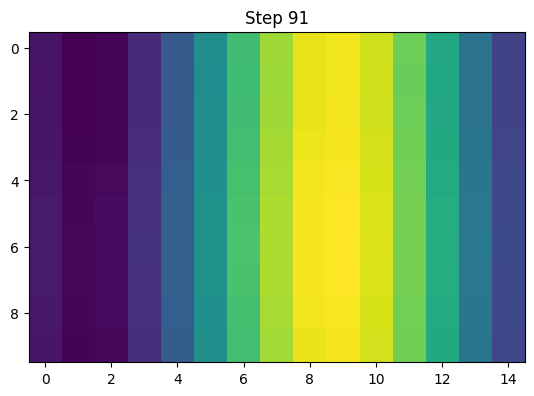

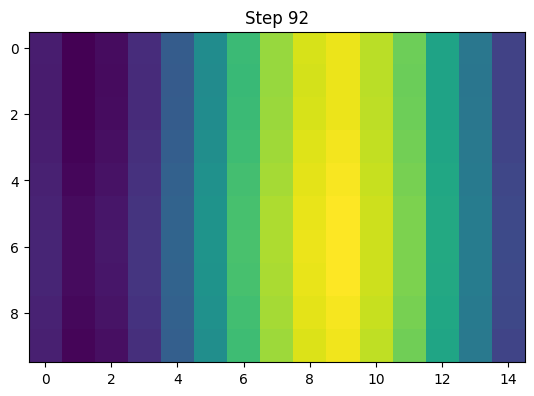

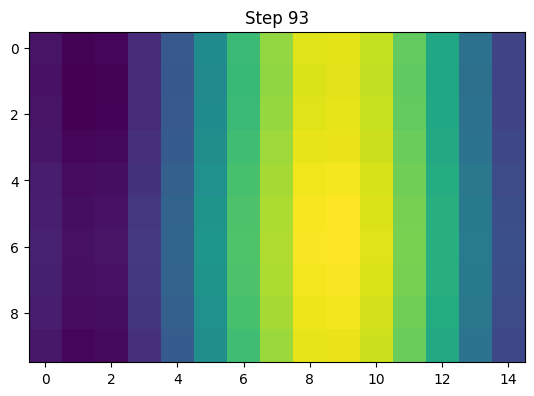

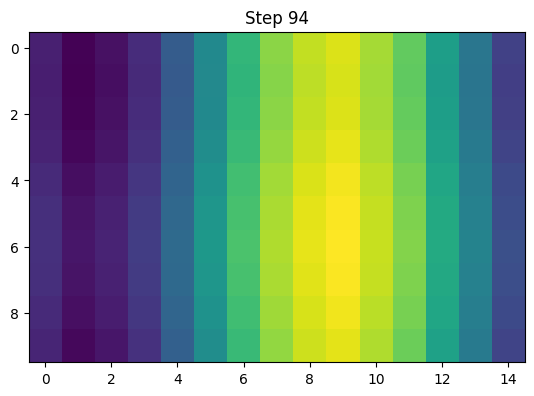

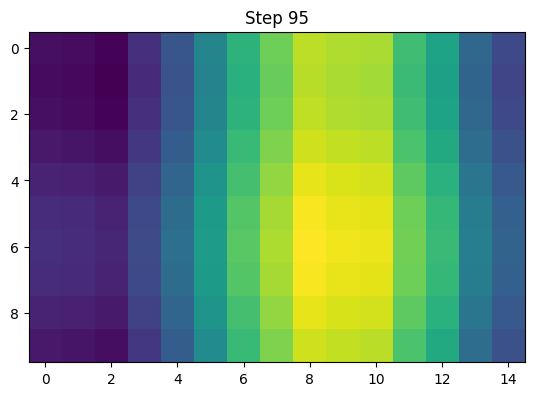

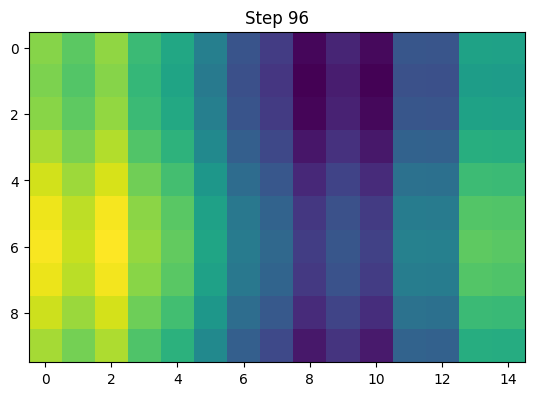

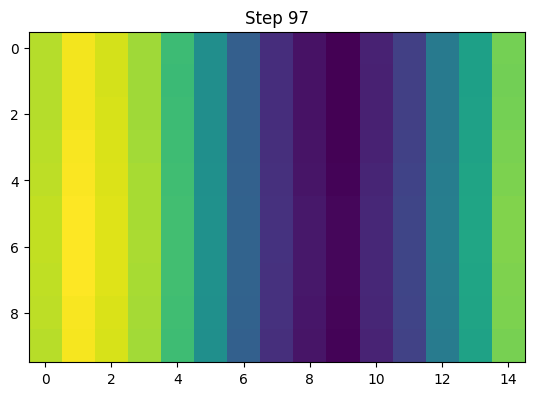

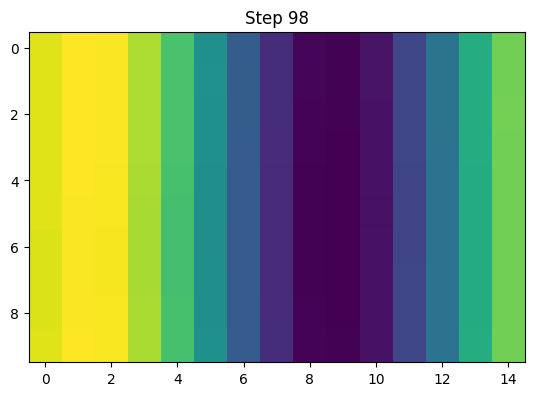

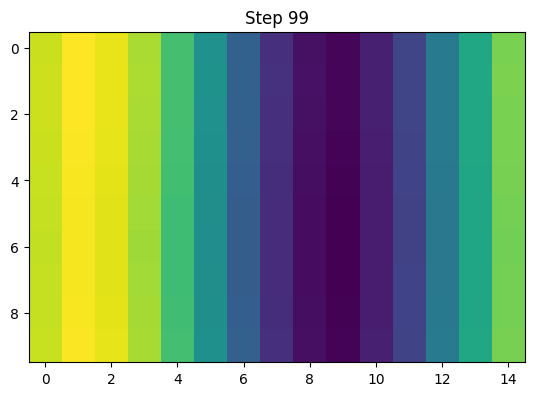

In [26]:
slen = 100
for i in range(slen):
    f, rho, u = plot_next_stream(f, i)